In [1]:
# 任务: 通过神经网络从原始数据中发现因子, 并拟合模型
import pandas as pd
from scutquant import scutquant, alpha

In [2]:
df_train = pd.read_csv('D:/Desktop/CSI300.csv')
df_test = pd.read_csv('D:/Desktop/CSI300_test.csv')
df_train.set_index(['datetime', 'instrument'], inplace=True)
df_test.set_index(['datetime', 'instrument'], inplace=True)

df = pd.concat([df_train, df_test], axis=0)

df['label'] = scutquant.price2ret(df['close'], shift1=-1, shift2=-2, groupby='instrument')

feature_kwargs = {
    'data': df,
    'open': 'open',
    'close': 'close',
    'high': 'high',
    'low': 'low',
    'volume': 'volume',
    'amount': 'amount',
    'groupby': 'instrument'
}
features = alpha.alpha360(feature_kwargs, shift=60)  # 所有因子皆为原始数据的滞后项
X = pd.concat([features, df['label']], axis=1)
X.describe()

,open1,open2,open3,open4,open5,open6,open7,open8,open9,open10,...,amount52,amount53,amount54,amount55,amount56,amount57,amount58,amount59,amount60,label
count,650972.000000,650662.000000,650352.000000,650042.000000,649732.000000,649422.000000,649112.000000,648802.000000,648492.000000,648182.000000,...,6.351620e+05,6.348520e+05,6.345420e+05,6.342320e+05,6.339220e+05,6.336120e+05,6.333020e+05,6.329920e+05,6.326820e+05,650662.000000
mean,0.999646,0.999795,0.999904,1.000015,1.000095,1.000132,1.000170,1.000211,1.000241,1.000267,...,1.977042e+07,1.978518e+07,1.980294e+07,1.981681e+07,1.982939e+07,1.984122e+07,1.985193e+07,1.986339e+07,1.987289e+07,0.001135
std,0.044860,0.057142,0.066541,0.074905,0.082198,0.088265,0.093960,0.099543,0.104605,0.109342,...,6.623241e+07,6.635428e+07,6.654349e+07,6.664863e+07,6.671317e+07,6.676878e+07,6.681087e+07,6.681601e+07,6.680570e+07,0.040568
min,0.166132,0.164244,0.160279,0.160846,0.156504,0.152917,0.160657,0.159797,0.160361,0.156032,...,5.635076e+03,5.622800e+03,5.825880e+03,5.865602e+03,5.852302e+03,5.725250e+03,5.855756e+03,5.905870e+03,5.960427e+03,-0.800138
25%,0.980881,0.975806,0.971578,0.967645,0.964224,0.961395,0.958751,0.956028,0.953425,0.951082,...,1.171942e+06,1.170693e+06,1.169456e+06,1.168118e+06,1.167081e+06,1.166324e+06,1.164347e+06,1.163058e+06,1.162900e+06,-0.012942
50%,1.000000,1.000000,1.000000,0.999706,0.999193,0.998865,0.998592,0.998437,0.998272,0.998062,...,3.629537e+06,3.629015e+06,3.627198e+06,3.627735e+06,3.625114e+06,3.625716e+06,3.624408e+06,3.621363e+06,3.621719e+06,0.000000
75%,1.017802,1.022530,1.026616,1.030229,1.033143,1.035667,1.037846,1.040128,1.042442,1.044444,...,1.466656e+07,1.466948e+07,1.466487e+07,1.467664e+07,1.467648e+07,1.466705e+07,1.468651e+07,1.468663e+07,1.469195e+07,0.012839
max,4.939980,4.836728,4.877892,4.977371,4.924201,4.939637,4.679046,5.279238,5.491916,5.248365,...,4.768045e+09,4.889997e+09,4.868689e+09,4.817841e+09,4.855877e+09,4.960305e+09,4.960305e+09,4.881570e+09,4.855877e+09,5.026166


<class 'pandas.core.frame.DataFrame'>
MultiIndex: 580608 entries, ('2010-01-04', '300003.SZ') to ('2021-12-31', '688981.SH')
Columns: 361 entries, open1 to label
dtypes: float64(361)
memory usage: 1.6+ GB
None
X_mis= 1.6134781779619614
clean dataset done 

pop label done 

label norm done 



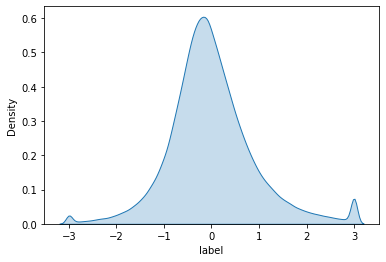

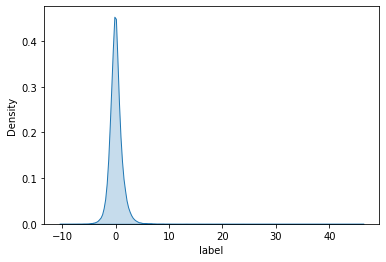

norm data done 

all works done 



,open1,open2,open3,open4,open5,open6,open7,open8,open9,open10,...,amount51,amount52,amount53,amount54,amount55,amount56,amount57,amount58,amount59,amount60
count,449703.000000,449703.000000,449703.000000,449703.000000,449703.000000,449703.000000,449703.000000,449703.000000,449703.000000,449703.000000,...,449703.000000,449703.000000,449703.000000,449703.000000,449703.000000,449703.000000,449703.000000,449703.000000,449703.000000,449703.000000
mean,0.004864,0.004706,0.004499,0.004229,0.003815,0.003576,0.003326,0.003137,0.002915,0.002629,...,-0.042320,-0.042312,-0.042339,-0.042371,-0.042382,-0.042427,-0.042444,-0.042481,-0.042546,-0.042623
std,0.939242,0.937807,0.938075,0.938857,0.940087,0.940261,0.940946,0.942728,0.943983,0.944755,...,0.763271,0.763121,0.762851,0.762358,0.761908,0.761729,0.761352,0.760852,0.760022,0.758771
min,-3.000000,-3.000000,-3.000000,-3.000000,-3.000000,-3.000000,-3.000000,-3.000000,-3.000000,-3.000000,...,-0.866692,-0.794467,-0.790496,-0.788564,-0.788675,-0.797058,-0.790408,-0.834285,-0.768228,-0.811923
25%,-0.496842,-0.500554,-0.502784,-0.508470,-0.514417,-0.519034,-0.521277,-0.528964,-0.533077,-0.534961,...,-0.451021,-0.450863,-0.450534,-0.450303,-0.450107,-0.449879,-0.449257,-0.448740,-0.448486,-0.447673
50%,0.059407,0.055797,0.054986,0.053984,0.052128,0.051447,0.051558,0.051919,0.051437,0.051838,...,-0.348774,-0.348307,-0.348131,-0.347944,-0.347455,-0.347721,-0.347596,-0.346821,-0.346067,-0.344739
75%,0.554828,0.553338,0.554440,0.557270,0.560307,0.562767,0.567569,0.571369,0.576129,0.578880,...,-0.006367,-0.006097,-0.006390,-0.007421,-0.007732,-0.007917,-0.008200,-0.008316,-0.009396,-0.010947
max,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,...,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000


In [3]:
X_test = X[X.index.isin(df_test.index)]
X = X[~X.index.isin(df_test.index)]
x_train, x_valid, y_train, y_valid, _, __ = scutquant.auto_process(X, 'label', groupby='instrument', datetime='datetime', 
                                                                         select=False, orth=False, label_norm=True)
x_train.describe()

In [4]:
# 手动处理测试集
X_test = X_test.groupby(['instrument']).fillna(method='ffill').dropna()
x_test = X_test.copy()
y_test = x_test.pop('label')
col = x_train.columns
x_test = x_test[col]
x_test = scutquant.zscorenorm(x_test, x_test.groupby("datetime").mean(), x_test.groupby("datetime").std())

ymean = y_test.groupby("instrument").shift(2).groupby("datetime").mean()
ystd = y_test.groupby("instrument").shift(2).groupby("datetime").std()
ymean.fillna(0, inplace=True)
ystd.fillna(1, inplace=True)

In [5]:
from tensorflow.keras import layers, models, optimizers, metrics, regularizers

rmse = metrics.RootMeanSquaredError(name="rmse")
model = models.Sequential([
    # 第一层: 相当于将原始数据换了一组基，得到新的360个特征, 每个新特征由所有原始特征的线性函数和一个非线性函数swish()合成
    layers.Dense(360, activation='swish', use_bias=False),  
    # 第二、三层: # 使用新的数据合成因子, 使用swish函数过滤噪声, 并进行正则化
    layers.Dense(1024, activation='swish', use_bias=False, kernel_regularizer=regularizers.l2(0.002)),  
    layers.LayerNormalization(),  # 因子标准化
    layers.Dense(1024, activation='swish', use_bias=False, kernel_regularizer=regularizers.l2(0.002)),  
    layers.LayerNormalization(),  # 因子标准化
    # 第四层: y_hat = W * X + b(岭回归, 加入了l2正则), W是因子收益率, X为因子, b即alpha收益(不随因子变化而变化)
    layers.Dense(1, kernel_regularizer=regularizers.l2(0.002))  
])
model.compile(optimizer=optimizers.Adam(0.0003), loss=metrics.mean_squared_error, metrics=[rmse, 'mae'])
history = model.fit(x_train, y_train, validation_data=(x_valid, y_valid), batch_size=128, epochs=20, verbose=1)

Epoch 1/20
3514/3514 [==============================] - 110s 31ms/step - loss: 2.2821 - rmse: 0.9297 - mae: 0.6806 - val_loss: 1.7261 - val_rmse: 1.2137 - val_mae: 0.8492
Epoch 2/20
3514/3514 [==============================] - 113s 32ms/step - loss: 0.9212 - rmse: 0.9125 - mae: 0.6657 - val_loss: 1.4879 - val_rmse: 1.2136 - val_mae: 0.8506
Epoch 3/20
3514/3514 [==============================] - 107s 30ms/step - loss: 0.8314 - rmse: 0.9081 - mae: 0.6636 - val_loss: 1.4758 - val_rmse: 1.2133 - val_mae: 0.8513
Epoch 4/20
3514/3514 [==============================] - 107s 31ms/step - loss: 0.8268 - rmse: 0.9077 - mae: 0.6632 - val_loss: 1.4773 - val_rmse: 1.2141 - val_mae: 0.8485
Epoch 5/20
3514/3514 [==============================] - 107s 30ms/step - loss: 0.8252 - rmse: 0.9072 - mae: 0.6627 - val_loss: 1.4737 - val_rmse: 1.2135 - val_mae: 0.8489
Epoch 6/20
3514/3514 [==============================] - 108s 31ms/step - loss: 0.8246 - rmse: 0.9070 - mae: 0.6626 - val_loss: 1.4740 - val_rmse:

In [6]:
pred = model.predict(x_test)
pred = pd.DataFrame(pred, columns=["predict"], index=x_test.index)
pred["predict"] += ymean
pred["predict"] *= ystd
pred.describe()

2205/2205 [==============================] - 10s 4ms/step


,predict
count,70552.000000
mean,-0.001204
std,0.014130
min,-0.308839
25%,-0.002456
50%,-0.001221
75%,0.000294
max,1.111045


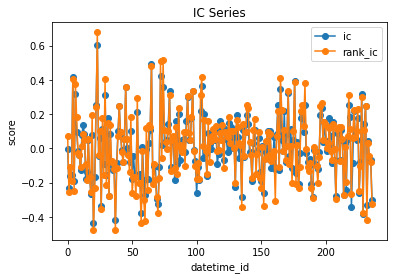

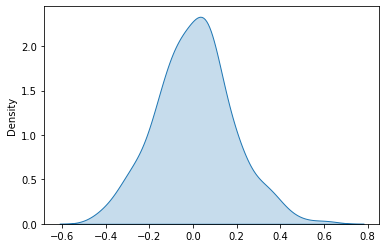

ic= 0.006407512676886806 icir= 0.03653704598498383 rank_ic= 0.007431576113091859 rank_icir= 0.03770228997871174


-0.00333628860498659

In [7]:
# 使用IC评判拟合优度
ic, icir, rank_ic, rank_icir = scutquant.ic_ana(pred, y_test, groupby='datetime')
print('ic=', ic, 'icir=', icir, 'rank_ic=', rank_ic, 'rank_icir=', rank_icir)
# 使用pearson相关系数评判拟合优度
r = scutquant.pearson_corr(pred.values, y_test)
r[0]

In [8]:
from scutquant import executor, report

# 将预测值处理成回测需要的格式
pred = executor.prepare(pred, df_test, time='datetime', price='close', volume='volume')
pred

predict           t        price     volume
time       code                                                   
2022-01-04 000001.SZ  0.093968  2022-01-04  1724.810723  116925933
           000002.SZ -0.105888  2022-01-04  2576.444458  194720202
           000063.SZ -0.077820  2022-01-04   420.676392   29003438
           000066.SZ -0.084781  2022-01-04   123.552888   83705296
           000069.SZ -0.224679  2022-01-04   270.898518   73778655
...                        ...         ...          ...        ...
2022-12-22 688363.SH -0.005573  2022-12-22   130.842543    4758190
           688396.SH -0.001425  2022-12-22    52.735905    2970253
           688561.SH -0.002211  2022-12-22    67.160000    1149844
           688599.SH  0.004227  2022-12-22    54.938671   19136216
           688981.SH -0.001869  2022-12-22    41.060000    6744443

[70252 rows x 4 columns]

Accuracy of Prediction: 0.5466463588225247


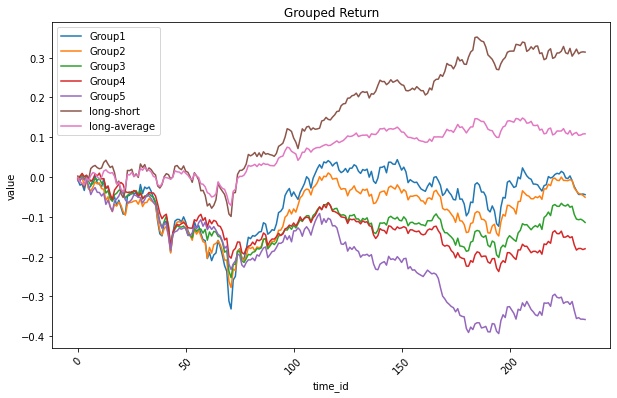

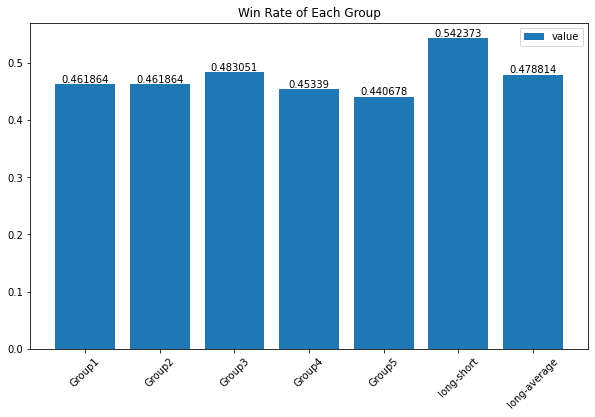

In [9]:
report.group_return_ana(pred, y_test)

In [10]:
backtest = {
    "generator": {
        "mode": "generate"
    },
    "strategy": {
        "class": "TopKStrategy",  # 做多预测值前20%且值大于0.5%的股票, 做空后20%且值小于0.5%的股票. 自动平仓
        "kwargs": {
            "auto_offset": True,
            "offset_freq": 2, # 应为delta_t + 1, 例如目标值是close_-2 / close_-1 - 1, 则delta_t = 1
            "buy_only": True,  # =True时，只做多不做空(在A股做空有一定的难度)
            "risk_degree": 0.95,  # 将风险度控制在这个数，如果超过了就按比例减持股票直到风险度小于等于它为止
            "unit": None,  # 由于数据已经是以手为单位, 故无需二次处理
            "max_volume": 0.002  # 手数随可用资金而改变，最大不会超过股票当天成交量的0.2%(例如T+1时下单，下单手数不会超过T时成交量的0.2%)
        }
    },
    "account": None,  # 使用默认账户, 即初始资金为1亿, 无底仓
    "trade_params": {
        "cost_buy": 0.0015,  # 佣金加上印花税
        "cost_sell": 0.0005,  
        "min_cost": 5,
    }
}
generator, strategy, account, trade_params = backtest["generator"], backtest["strategy"], backtest["account"], backtest["trade_params"]
exe = executor.Executor(generator, strategy, account, trade_params)
exe.execute(data=pred, verbose=0)

E(r): -0.03973981715670209
std: 0.01780574450571174
E(r_benchmark): -0.12867191898052116
std_benchmark: 0.05329655828798661 

Cumulative Rate of Return: -0.062227554221033765
Cumulative Rate of Return(benchmark): -0.1858229210189083
Cumulative Excess Rate of Return: 0.12359536679787453 

Max Drawdown: -0.0998462336204804
Max Drawdown(benchmark): -0.23197087771901204 

Sharpe Ratio: -2.2364697485550167
Sortino Ratio: 23.223433394610687
Information Ratio: 4.994573621748383 

Pearson Correlation Coefficient Between Return and Benchmark: 0.897143169047431
Profitable Days(%): 0.0


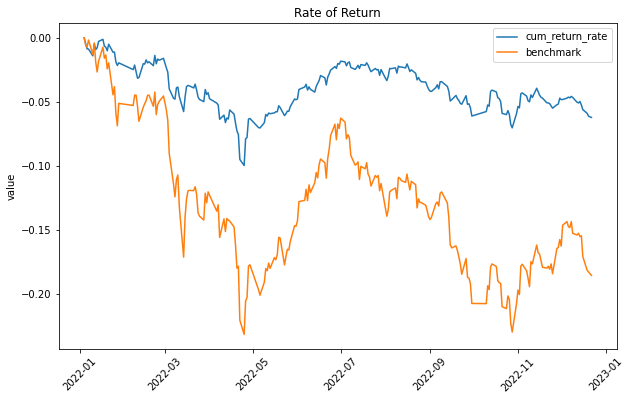

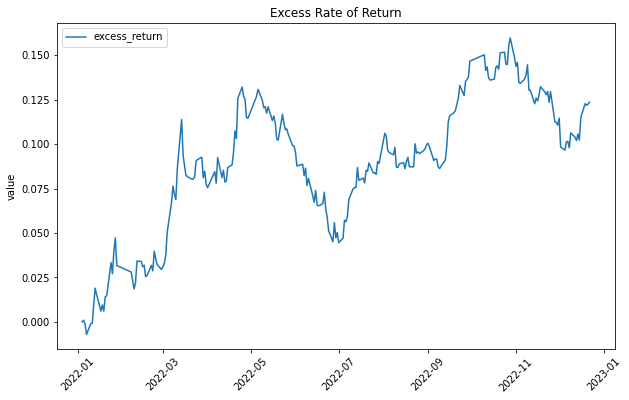

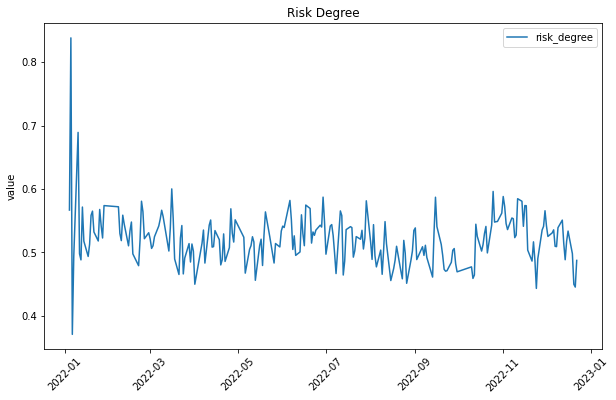

In [11]:
user_account, benchmark = exe.user_account, exe.benchmark
report.report_all(user_account, benchmark, freq=365, time=exe.time)  # 无风险收益率默认为年化3%，可以通过参数rf调节

In [13]:
model.save("dnn")

INFO:tensorflow:Assets written to: dnn\assets


INFO:tensorflow:Assets written to: dnn\assets
